In [ ]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 123MB/s]


In [ ]:
!unzip /content/diabetes-health-indicators-dataset.zip -d /content/diabetes-health-indicators-dataset

Archive:  /content/diabetes-health-indicators-dataset.zip
  inflating: /content/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: /content/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [ ]:
features = pd.read_csv('/content/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [ ]:
features.columns

Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

# PreProcessing


In [ ]:
# gộp
features.loc[features['Education'] < 3, 'Education'] = 3
features['Education'] -= 3


In [ ]:
# loại bỏ các dữ liệu trùng lặp
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)
Sscaler = StandardScaler()
Rscaler = RobustScaler()
Mscaler = MinMaxScaler()
features_standardized = pd.DataFrame(Sscaler.fit_transform(features), columns=features.columns)
features_robust = pd.DataFrame(Rscaler.fit_transform(features), columns=features.columns)
features_MinMax = pd.DataFrame(Mscaler.fit_transform(features), columns=features.columns)



features[['BMI', 'Age', 'GenHlth']] = features_standardized[['BMI', 'Age', 'GenHlth']]
features[['MentHlth', 'PhysHlth']] = features_robust[['MentHlth', 'PhysHlth']]
features[['Education', 'Income']] = features_MinMax[['Education', 'Income']]


# chia tập thành train | val | test

In [ ]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd

# Giả sử bạn đã có các model và tham số cho từng model
models = {
    'SVM': (SVC(), {'kernel': ['rbf', 'poly', 'sigmoid'], 'C':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 'gamma': ['scale', 'auto']}),
    'LinearSVM': (LinearSVC(), {'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}),
}

# Lưu kết quả cho tất cả model
results = []

for model_name, (model, params) in models.items():
    grid = GridSearchCV(model, params, scoring='f1_macro', cv=5, n_jobs=-1, )
    grid.fit(x_train, y_train)

    # Lưu kết quả vào DataFrame
    for mean, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
        results.append({
            'Model': model_name,
            'Mean F1 score - macro': mean,
            'Parameters': params
        })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Tìm model tốt nhất
best_model = results_df.loc[results_df['Mean F1 score - macro'].idxmax()]
print("\nBest Model:\n", best_model)
results_df.to_csv('service_usage.csv')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd

# Giả sử bạn đã có các model và tham số cho từng model
models = {
    'SVM': (SVC(), {'kernel': ['poly'], 'C':[0.5], 'gamma': ['scale', 'auto'], 'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]}),
}

# Lưu kết quả cho tất cả model
results = []

for model_name, (model, params) in models.items():
    grid = GridSearchCV(model, params, scoring='f1_macro', cv=5, n_jobs=-1)
    grid.fit(x_train, y_train)

    # Lưu kết quả vào DataFrame
    for mean, params in zip(grid.cv_results_['mean_test_score'], grid.cv_results_['params']):
        results.append({
            'Model': model_name,
            'Mean F1 score - macro': mean,
            'Parameters': params
        })

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Tìm model tốt nhất
best_model = results_df.loc[results_df['Mean F1 score - macro'].idxmax()]
print("\nBest Model:\n", best_model)
results_df.to_csv('service_usage.csv')

In [ ]:
best_model = SVC(kernel='poly', C=0.5, gamma='auto')
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.7532594785174919

Đặc trưng GenHlth: 0.0444
Đặc trưng BMI: 0.0261
Đặc trưng Age: 0.0231
Đặc trưng HighBP: 0.0195
Đặc trưng HighChol: 0.0073
Đặc trưng CholCheck: 0.0070
Đặc trưng PhysHlth: 0.0026
Đặc trưng Income: 0.0024
Đặc trưng Sex: 0.0022
Đặc trưng HeartDiseaseorAttack: 0.0021
Đặc trưng HvyAlcoholConsump: 0.0017
Đặc trưng DiffWalk: 0.0016
Đặc trưng MentHlth: 0.0013
Đặc trưng Education: 0.0007
Đặc trưng Fruits: 0.0006
Đặc trưng Stroke: 0.0006
Đặc trưng AnyHealthcare: 0.0003
Đặc trưng Smoker: 0.0003
Đặc trưng Veggies: 0.0003
Đặc trưng NoDocbcCost: -0.0000
Đặc trưng PhysActivity: -0.0001


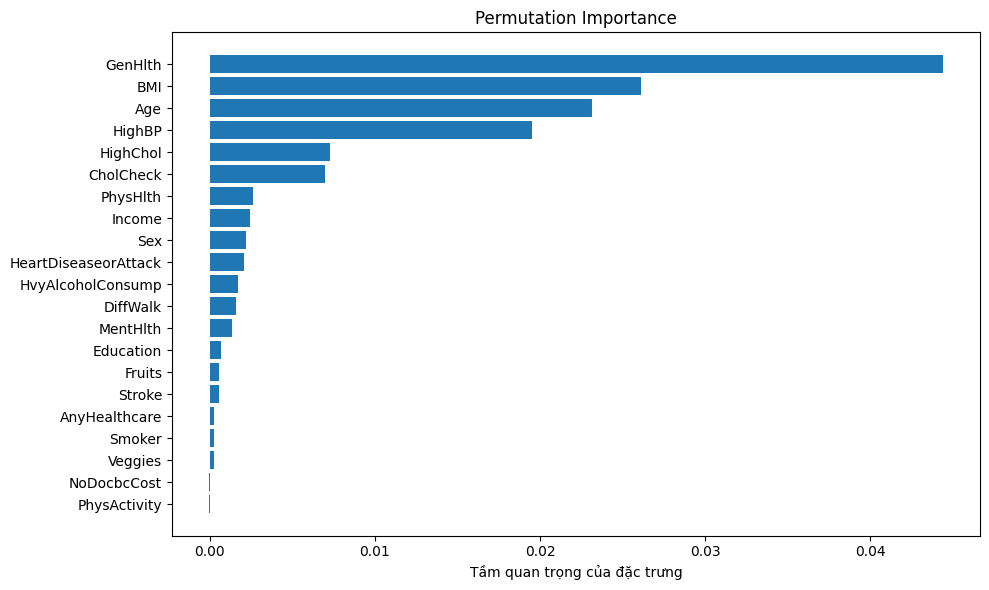

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best_model, x_val, y_val, n_repeats=50, random_state=42, scoring='f1_macro', n_jobs=-1)

sorted_idx = result.importances_mean.argsort()
# Hiển thị kết quả
for i in result.importances_mean.argsort()[::-1]:
    print(f"Đặc trưng {features.columns[i+1]}: {result.importances_mean[i]:.4f} +-  {result.importances_std[i]:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [features.columns[i+1] for i in sorted_idx])
plt.xlabel("Tầm quan trọng của đặc trưng")
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()

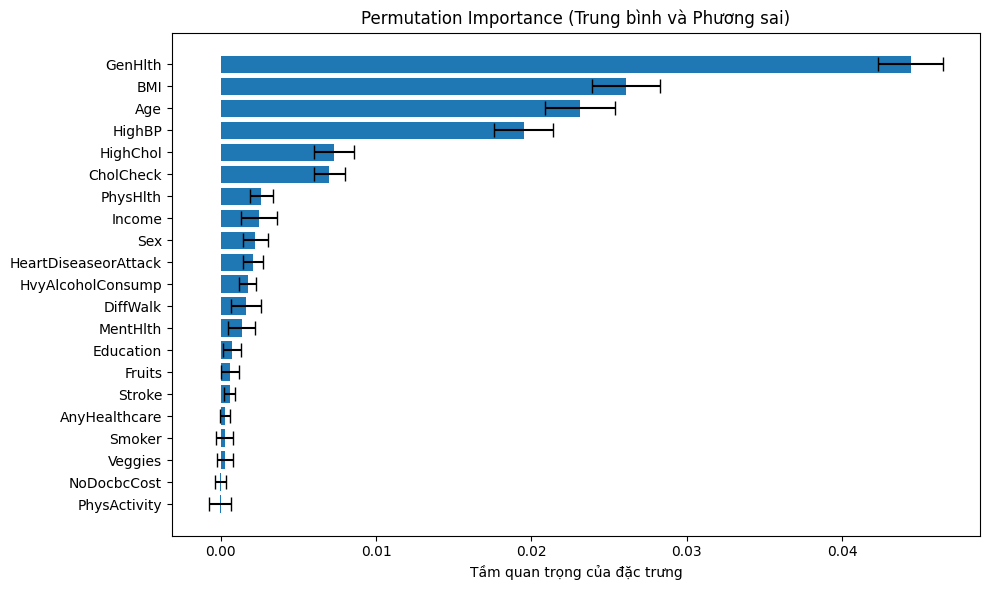

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Giả sử `result.importances_mean` là giá trị trung bình và `result.importances_std` là phương sai
means = result.importances_mean[sorted_idx]
stds = result.importances_std[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(
    range(len(sorted_idx)),
    means,
    xerr=stds,  # Thêm phương sai vào đây
    align="center",
    alpha=1,  # Tùy chỉnh độ trong suốt
    capsize=5  # Kích thước các đường gạch ngang của lỗi
)
plt.yticks(range(len(sorted_idx)), [features.columns[i+1] for i in sorted_idx])
plt.xlabel("Tầm quan trọng của đặc trưng")
plt.title("Permutation Importance (Trung bình và Phương sai)")
plt.tight_layout()
plt.show()

In [ ]:
copy = features.copy()

In [ ]:
indices = [copy.columns.get_loc(name) - 1  for name in ['PhysActivity', 'NoDocbcCost']]

In [ ]:
indices

[7, 12, 4, 11]

In [ ]:
X_train = np.concatenate((x_train, x_val), axis=0)
Y_train = np.concatenate((y_train, y_val), axis=0)
# X_train = np.delete(X_train, indices, axis=1)
# X_test = np.delete(x_test, indices, axis=1)

In [ ]:
best_model = SVC(kernel='poly', C=0.5, gamma='auto', )
best_model.fit(X_train, Y_train)



SVC(C=0.5, gamma='auto', kernel='poly')

In [ ]:
y_pred = best_model.predict(x_test)
f1_score(y_test, y_pred, average='macro')

0.7535670653849571

In [ ]:
# Add this line at the beginning of your code to import the function:
from sklearn.metrics import classification_report

# ... (rest of your code) ...

# Now you should be able to call the function:
classification_report(y_test, y_pred, output_dict=True)

{'0.0': {'precision': 0.7852360227653163,
  'recall': 0.6906654888103652,
  'f1-score': 0.7349208835970547,
  'support': 6792.0},
 '1.0': {'precision': 0.731912721704734,
  'recall': 0.8172104288360166,
  'f1-score': 0.7722132471728594,
  'support': 7019.0},
 'accuracy': 0.7549779161537905,
 'macro avg': {'precision': 0.7585743722350251,
  'recall': 0.7539379588231909,
  'f1-score': 0.7535670653849571,
  'support': 13811.0},
 'weighted avg': {'precision': 0.7581361567060717,
  'recall': 0.7549779161537905,
  'f1-score': 0.7538735372744548,
  'support': 13811.0}}

In [ ]:
X_train = np.concatenate((x_train, x_val), axis=0)
Y_train = np.concatenate((y_train, y_val), axis=0)
X_train = np.delete(X_train, indices, axis=1)
X_test = np.delete(x_test, indices, axis=1)

In [ ]:
best_model = SVC(kernel='poly', C=0.5, gamma='auto', )
best_model.fit(X_train, Y_train)
y_pred = best_model.predict(X_test)
f1_score(y_test, y_pred, average='macro')

0.7524387357666813

In [ ]:
# Add this line at the beginning of your code to import the function:
from sklearn.metrics import classification_report

# ... (rest of your code) ...

# Now you should be able to call the function:
classification_report(y_test, y_pred, output_dict=True)

{'0.0': {'precision': 0.7818786367414796,
  'recall': 0.692432273262662,
  'f1-score': 0.7344421019754822,
  'support': 6792.0},
 '1.0': {'precision': 0.7320420728578758,
  'recall': 0.8130787861518735,
  'f1-score': 0.7704353695578805,
  'support': 7019.0},
 'accuracy': 0.7537470132503077,
 'macro avg': {'precision': 0.7569603547996777,
  'recall': 0.7527555297072677,
  'f1-score': 0.7524387357666813,
  'support': 13811.0},
 'weighted avg': {'precision': 0.7565507935803027,
  'recall': 0.7537470132503077,
  'f1-score': 0.7527345315722423,
  'support': 13811.0}}